# 任务描述

- 基于MNIST数据集，设计分类器实现手写数字分类。


# 数据描述

[MNIST](http://yann.lecun.com/exdb/mnist/)数据集，包含60,000个训练集样本与10,000个测试集样本。

每个样本是一个28\*28的灰度图：

Magic: 2051, Total Images: 60000, Size: 28*28
Magic: 2049, Total Images: 60000
Magic: 2051, Total Images: 10000, Size: 28*28
Magic: 2049, Total Images: 10000


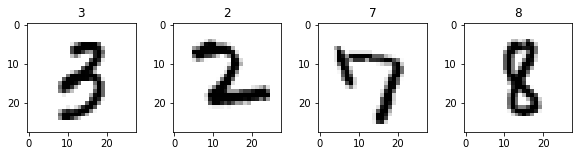

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct


def decode_idx3_ubyte(idx3_ubyte_file):
    bin_data = open(idx3_ubyte_file, 'rb').read()
    offset = 0
    fmt_header = '>iiii'
    magic_number, num_images, num_rows, num_cols = \
        struct.unpack_from(fmt_header, bin_data, offset)
    print('Magic: %d, Total Images: %d, Size: %d*%d' % 
          (magic_number, num_images, num_rows, num_cols))
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header)
    fmt_image = '>' + str(image_size) + 'B'
    images = np.empty((num_images, num_rows, num_cols))
    for i in range(num_images):
        images[i] = np.array(
            struct.unpack_from(fmt_image, bin_data, offset)) \
            .reshape((num_rows, num_cols))
        offset += struct.calcsize(fmt_image)
    return images


def decode_idx1_ubyte(idx1_ubyte_file):
    bin_data = open(idx1_ubyte_file, 'rb').read()
    offset = 0
    fmt_header = '>ii'
    magic_number, num_images = \
        struct.unpack_from(fmt_header, bin_data, offset)
    print('Magic: %d, Total Images: %d' % (magic_number, num_images))
    offset += struct.calcsize(fmt_header)
    fmt_image = '>B'
    labels = np.empty(num_images)
    for i in range(num_images):
        labels[i], = struct.unpack_from(fmt_image, bin_data, offset)
        offset += struct.calcsize(fmt_image)
    return labels


def prepare_dataset(images_file, labels_file, size, num=None):
    images = decode_idx3_ubyte(images_file)
    images = images.reshape((-1, size))
    labels = decode_idx1_ubyte(labels_file)
    labels = np.array(labels, dtype=np.int)
    # shuffle
    idx = np.arange(labels.shape[0])
    np.random.shuffle(idx)
    if num is not None:
        idx = idx[:num]
    images = images[idx]
    labels = labels[idx]
    return images, labels


train_images_idx3_ubyte_file = './mnist/train-images.idx3-ubyte'
train_labels_idx1_ubyte_file = './mnist/train-labels.idx1-ubyte'
test_images_idx3_ubyte_file = './mnist/t10k-images.idx3-ubyte'
test_labels_idx1_ubyte_file = './mnist/t10k-labels.idx1-ubyte'
SIZE = 28 * 28

np.random.seed(1)

train_images, train_labels = \
    prepare_dataset(train_images_idx3_ubyte_file,
                    train_labels_idx1_ubyte_file, SIZE)
test_images, test_labels = \
    prepare_dataset(test_images_idx3_ubyte_file,
                    test_labels_idx1_ubyte_file, SIZE)

plt.figure(figsize=(10, 2))
for i in range(4):
    ax = plt.subplot(141 + i)
    plt.imshow(train_images[i].reshape((28, 28)), cmap='binary')
    ax.set_title(str(train_labels[i]))
plt.show()

# 数据预处理

将图像灰度值映射到$[0,1]$之间：

In [2]:
train_images /= 255
test_images /= 255

# 算法介绍

## 多层感知机-神经网络（MLP-NN）

### 算法原理

多层感知机的预测结果：
$$\boldsymbol{y}=\boldsymbol{w}_2^{\top}\sigma\left(\boldsymbol{w}_1^{\top}\boldsymbol{X}+\boldsymbol{b}_1\right)+\boldsymbol{b}_2$$
其中，$\boldsymbol{w}_1\in\mathbb{R}^{M\times H}$，$\boldsymbol{b}_1\in\mathbb{R}^{H}$，$\boldsymbol{w}_2\in\mathbb{R}^{H\times K}$，$\boldsymbol{b}_2\in\mathbb{R}^{K}$，$K$为类别数，$H$为隐藏层大小，$\sigma(\cdot)$为非线性激活函数。


### 算法实现

本报告基于Tensorflow实现多层感知机-神经网络（TF-MLP-NN）。使用2种激活函数，分别对应不同的损失函数：

- ReLU激活函数与Softmax Cross Entropy损失函数（TF-MLP-NN-BCE）；

- Sigmoid激活函数与平方损失函数（TF-MLP-NN-Sqr）。


In [ ]:
class MLP:

    def __init__(self, n_features, n_hidden, n_classes,
                 alpha=0.0001, fn='relu_bce'):
        w1 = tf.Variable(tf.random_normal([n_features, n_hidden]))
        b1 = tf.Variable(tf.random_normal([1, n_hidden]))
        w2 = tf.Variable(tf.random_normal([n_hidden, n_classes]))
        b2 = tf.Variable(tf.random_normal([1, n_classes]))
        self.X = tf.placeholder(dtype=tf.float32,
                                shape=[None, n_features])
        self.y = tf.placeholder(dtype=tf.float32,
                                shape=[None, n_classes])
        if fn == 'relu_bce':
            h = tf.nn.relu(tf.matmul(self.X, w1) + b1)
            self.pred = tf.matmul(h, w2) + b2
            self.loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y,
                                                           logits=self.pred))
        else:  # sigmoid_sqr
            h = tf.nn.sigmoid(tf.matmul(self.X, w1) + b1)
            self.pred = tf.nn.sigmoid(tf.matmul(h, w2) + b2)
            self.loss = tf.reduce_mean(
                (self.y - self.pred) ** 2)
        self.loss += alpha * (tf.reduce_sum(w1 ** 2)
                              + tf.reduce_sum(w2 ** 2))
        optimizer = tf.train.AdamOptimizer()
        grads_and_vars = optimizer.compute_gradients(self.loss)
        self.train_op = optimizer.apply_gradients(grads_and_vars)


batch_size = 500
n_epochs = 200
idx = np.arange(train_images.shape[0], dtype=np.int)
train_labels = np.eye(10)[train_labels]

best = 0

with tf.Graph().as_default():
    tf.set_random_seed(1)
    classifier = MLP(SIZE, 100, 10)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(n_epochs):
            print('epoch', epoch)
            # train
            np.random.shuffle(idx)
            for k in range(0, train_images.shape[0], batch_size):
                batch_idx = idx[k:min(k + batch_size,
                                      train_images.shape[0])]
                batch_image = train_images[batch_idx]
                batch_label = train_labels[batch_idx]
                sess.run(classifier.train_op, feed_dict={
                    classifier.X: batch_image,
                    classifier.y: batch_label
                })
            # evaluate
            pred = sess.run(tf.argmax(classifier.pred, axis=-1),
                            feed_dict={
                classifier.X: test_images
            })
            correct = np.sum(pred == test_labels)
            accuracy = correct / test_labels.shape[0]
            print('accuracy:',
                  correct, '/', test_labels.shape[0],
                  '=', accuracy)
            best = max(best, accuracy)

print('-' * 30)
print('best:', best)

# 实验结果与分析

本报告使用正确率作为评价指标，正确率是分类器正确分类的数量与测试集总量的比值。


## 实验结果

调用Scikit-Learn中的MLP（SL-MLP-NN）：

In [ ]:
from sklearn.neural_network import MLPClassifier

pred = MLPClassifier() \
    .fit(train_images, train_labels) \
    .predict(test_images)
correct = np.sum(pred == test_labels)
total = test_labels.shape[0]
print(correct / total)

汇总的实验结果：

|模型|准确率|
|:-:|:-:|
|SL-MLP-NN|0.9780|
|TF-MLP-NN-Sqr|0.9156|
|TF-MLP-NN-BCE|0.9813|


## 实验结果分析

实验中，TF-MLP-NN-BCE预测性能超过SL-MLP-NN。使用ReLU+Softmax Cross Entropy的TF-MLP-NN-BCE比使用Sigmoid+平方损失函数的TF-MLP-NN-Sqr预测性能更好，说明激活函数与损失函数会影响MLP-NN的预测性能。